In [1]:
def get_data(origin,maximum, Lleyland = False, Brett = True):
    bore_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="bore_info"
    )
    
    df = bore_info.copy()
    x0, x1, y0, y1, z0, z1 = origin[0], maximum[0], origin[1], maximum[1], origin[2], maximum[2]
    df = df.loc[(df["Northing"] >= y0)]
    df = df.loc[(df["Northing"] <= y1)]
    df = df.drop(["Source"], axis=1)
    df = df.reset_index(drop=True)

    lithcodes = list(df.columns.values[3:])  # Make a list of formations
    df.Easting = pd.to_numeric(df.Easting)
    df.Northing = pd.to_numeric(df.Northing)
    df.Ground = pd.to_numeric(df.Ground)
    print(lithcodes)
    
    strat_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="strat_info"
    )

    strat = []
    vdum = [ 38,
            -10,
            -52,
            -124,
            -320,
            -385,
            -435,
            -463,
            -472,
            -494,
            -549,
            -591,
            -657,
            -685,
            -732,
            -888,
            -947,
            -1029,
            -1109,
            -1884,
            -2156,
            -2214,
            -3214,
            -4214
            ]

    for i, lith in enumerate(lithcodes):
        index = i
        lithid = i - 1
        val = vdum[i]
        sequence = strat_info.loc[strat_info["unit"] == lith, "sequence"].item()
        R = strat_info.loc[strat_info["unit"] == lith, "R"].item() / 255
        G = strat_info.loc[strat_info["unit"] == lith, "G"].item() / 255
        B = strat_info.loc[strat_info["unit"] == lith, "B"].item() / 255
        strat.append(
            [index, lithid, lith, sequence, val, [round(R, 2), round(G, 2), round(B, 2)]]
        )
    strat = pd.DataFrame(strat)
    strat.columns = ["index", "lithid", "lithcode", "sequences", "vals", "color"]

    data_list = df.values.tolist()  # Turn data into a list of lists
    formatted_data = []
    for i in range(len(data_list)):  # iterate for each row
        end = False
        # okay, first we will establish the max value (i.e. the end of the hole)
        stuff = []
        for j in range(3, 26, 1):
            if isinstance(data_list[i][j], numbers.Number) == True:
                stuff.append(data_list[i][j])

        EOH = max(stuff)
        #print(EOH)

        boreid = data_list[i][2]
        easting, northing = data_list[i][0], data_list[i][1]
        groundlevel = data_list[i][3]
        # First channp.nan, np.nan, np.nange - we can get the norms from the geophys data...
        gx, gy, gz = 0.0, 0.0, 1.0  # np.nan, np.nan,np.nan

        # Add data for groundlevel
        val = strat.vals[0]
        formatted_data.append(
            [
                boreid,
                easting,
                northing,
                groundlevel,
                val,
                "Ground",
                "Quaternary",
                gx,
                gy,
                gz,
                "raw_data"
            ]
        )  # eventually we cn get this from a dem...
        current_bottom = np.copy(groundlevel)

        if isinstance(data_list[i][4], numbers.Number) == True:
            bottom = groundlevel - float(data_list[i][4])  # Ground surface - TQ (mbgl)
            val = strat.vals[1]  # designated isovalue
            lithid = lithcodes[1]  # lithology id
            feat_name = strat.sequences[1]  # sequence name
            formatted_data.append(
                [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz,"raw_data"]
            )
            current_bottom = np.copy(bottom)
        non_conform = [0, #base Quaternary
                       4, #Base Tertiary
                       5, #Base lancelin
                       6, #Base Poison Hill
                       9,#Base Mirrabooka
                       12,#Base Henley
                       15,#Base Mariginiup
                       17,#Base Gage , where absent, make conformal bu adding a point in waneroo
                       18,#Base Carnac
                       20,#Base Ottorowirri
                       21,#Base Yarragadee
                       22]
        #This will just tuck the feature up above the unconformity if it is the first in the strat column and absent"
        top_feat = [1,5,6,7,10,13,16,18,19] 
        non_conform_name = ["NC0","NC1","NC2","NC3","NC4","NC5","NC6","NC7","NC8","NC9","NC10","NC11"]
        #gx, gy, gz = np.nan, np.nan,np.nan
        # I know, I know, there isn't any of the tertiary one here, but in being thorough...
        flags = []
        zdum = []
        for j in range(5, 26, 1):
            if isinstance(data_list[i][j], numbers.Number) == True:
                if data_list[i][j] < EOH:
                    flags.append(1)
                    bottom = groundlevel - float(
                        data_list[i][j])
                    zdum.append(bottom)
                    # Ground surface - TQ (mbgl)
                    val = strat.vals[j - 3]  # designated isovalue
                    end = False
                else:
                    bottom = np.copy(current_bottom)  # Ground surface - TQ (mbgl)
                    zdum.append(groundlevel - float(
                        data_list[i][j]))
                    val = strat.vals[j - 4]  # designated isovalue
                    end = True
                    flags.append(2)
                lithid = lithcodes[j - 3]  # lithology id
                feat_name = strat.sequences[j - 3]  # sequence name
                formatted_data.append(
                    [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz,"raw_data"]
                )
                current_bottom = np.copy(bottom)
            #unconfirmities
                """if strat.lithid[j - 3] in top_feat and EOH == False:
                    val = strat.vals[j - 4]
                    bdum = bottom+ 1.
                    feat_name = strat.sequences[j - 3]
                    lithid = lithcodes[j - 3]
                    formatted_data.append(
                        [boreid, easting, northing, bdum, val, lithid, feat_name, gx, gy, gz]
                    )"""         
            else: 
                
                if not end:
                    zdum.append(current_bottom)
                    flags.append(0)
                else:
                    zdum.append(np.nan)
                    flags.append(-1)
                
            if strat.lithid[j - 3] in non_conform:
                if end == False:
                    idx = non_conform.index(strat.lithid[j - 3])
                    bottom = np.copy(current_bottom)
                    val = 0.0
                    lithid = non_conform_name[idx]
                    feat_name = non_conform_name[idx] + '_FEAT' 
                    formatted_data.append(
                        [boreid, easting, northing, bottom, val, lithid, feat_name, 0.0, 0.0, 1.0,"raw_data"]
                    ) 
        if flags[15] == 0 and flags[16] == 0:
            if not np.isnan(zdum[16]):
                val = -1109
                feat_name = strat.sequences[18]
                lithid = lithcodes[18] + '_con'
                #print(feat_name,lithid,zdum[16])
                formatted_data.append(
                        [boreid, easting, northing, zdum[16], val, lithid, feat_name, 0.0, 0.0, 1.0,"force_conform"]
                    )
        if flags[17] == 0 and flags[18] == 0  and flags[19] == 0:
            if not np.isnan(zdum[19]):
                val = 0.
                feat_name = "NC9_FEAT"
                lithid = "yar_dum"   
                formatted_data.append(
                        [boreid, easting, northing, zdum[19], val, lithid, feat_name, 0.0, 0.0, 1.0,"force_conform"]
                    )
                
    data = pd.DataFrame(formatted_data)
    data.columns = [
        "ID",
        "X",
        "Y",
        "Z",
        "val",
        "lithcode",
        "feature_name",
        "gx",
        "gy",
        "gz",
        "for_Kerry"
    ]
    
    if Lleyland:
        valdum = [38.,-10.,0.,0.,-732,-888,-947,-1029,0][::-1]
        feature = ['Quaternary','Quaternary','NC1_FEAT','NC5_FEAT',
                   'Leederville','Leederville','Leederville'
                   ,'Warnbro','NC7_FEAT'][::-1]
        
        ddum = []
        Lley = pd.read_excel(
        "../data/Dwer_data\Formation picks.xls", sheet_name="Lleyland"
        )

        for i in range(len(Lley)):
            BoreID = Lley["Name"][i]
            X = Lley["East"][i]
            Y = Lley["North"][i]
            LSE = Lley["Ground"][i]
            ddum.append([BoreID, X, Y, LSE, valdum[-1], 'Lley', feature[-1], 0.0, 0.0, 1.0,"Lucy"])
            ddum.append([BoreID, X, Y, LSE-Lley["Break up"][i], valdum[0], 'Lley', feature[0], 0.0, 0.0, 1.0,"Lucy"]) 
            if type(Lley["SPS"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["SPS"][i], valdum[1], 'Lley', feature[1], 0.0, 0.0, 1.0,"Lucy"])
            if type(Lley["Maringiniup"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Maringiniup"][i], valdum[2], 'Lley', feature[2], 0.0, 0.0, 1.0,"Lucy"])            
            ddum.append([BoreID, X, Y, LSE-Lley["Waneroo"][i], valdum[3], 'Lley', feature[3], 0.0, 0.0, 1.0,"Lucy"])
            if type(Lley["Pinjar"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Pinjar"][i], valdum[4], 'Lley', feature[4], 0.0, 0.0, 1.0,"Lucy"])                    
            ddum.append([BoreID, X, Y, LSE-Lley["Aptian"][i], valdum[5], 'Lley', feature[5], 0.0, 0.0, 1.0,"Lucy"])   
            if type(Lley["Paleocene"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Paleocene"][i], valdum[5], 'Lley', feature[5], 0.0, 0.0, 1.0,"Lucy"]) 
            ddum.append([BoreID, X, Y, LSE-Lley["TQ"][i], valdum[6], 'Lley', feature[6], 0.0, 0.0, 1.0,"Lucy"]) 

        data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)])
        
    if Brett:
        gphys = pd.read_excel(
        "../data/Dwer_data\Formation picks.xls", sheet_name="Other_constraints")
        ddum = []
        for i in range(len(gphys)):
            ddum.append(['GEO', gphys["Easting"][i], gphys["Northing"][i], gphys["z"][i], gphys["val"][i], 'GEO', gphys["Feature"][i], 0.0, 0.0, 1.0,"Brett"]) 

        data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)]) 
        
    return(data,lithcodes)
   

    

In [2]:
def make_strat_column(lithcodes):
    strat_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="strat_info"
    )
    
    strat = []
    vdum = [ 38,
            -10,
            -52,
            -124,
            -320,
            -385,
            -435,
            -463,
            -472,
            -494,
            -549,
            -591,
            -657,
            -685,
            -732,
            -888,
            -947,
            -1029,
            -1109,
            -1884,
            -2156,
            -2214,
            -3214,
            -4214
            ]

    for i, lith in enumerate(lithcodes):
        index = i
        lithid = i - 1
        val = vdum[i]
        sequence = strat_info.loc[strat_info["unit"] == lith, "sequence"].item()
        R = strat_info.loc[strat_info["unit"] == lith, "R"].item() / 255
        G = strat_info.loc[strat_info["unit"] == lith, "G"].item() / 255
        B = strat_info.loc[strat_info["unit"] == lith, "B"].item() / 255
        strat.append(
            [index, lithid, lith, sequence, val, [round(R, 2), round(G, 2), round(B, 2)]]
        )
    strat = pd.DataFrame(strat)
    strat.columns = ["index", "lithid", "lithcode", "sequences", "vals", "color"]
    
    stratigraphic_column = {}
    stratigraphic_column["Quaternary"] = {}
    stratigraphic_column["Tertiary"] = {}
    stratigraphic_column["Coolyena_1a"] = {}
    stratigraphic_column["Coolyena_1b"] = {}
    stratigraphic_column["Coolyena_2"] = {}
    stratigraphic_column["Coolyena_3"] = {}
    stratigraphic_column["Leederville"] = {}
    stratigraphic_column["Warnbro"] = {}
    #stratigraphic_column["Carnac"] = {}
    stratigraphic_column["Parmelia"] = {}
    stratigraphic_column["Yarragadee"] = {}

    tops = [0,5,6,7,8,11,14,17,19,22]
    bots = [5,6,7,10,13,16,18,21,22]
    for i in range(0, len(strat) - 1, 1):
        if i in tops:
            maxval = np.inf
        else:
            maxval = strat.vals[i - 1]
        if i in bots:
             minval = -np.inf
        else:
            minval = strat.vals[i]       
        stratigraphic_column[strat.sequences[i]][strat.lithcode[i]] = {
            "min": minval,
            "max": maxval,
            "id": i,
            "color": strat.color[i],
        }
        
    return(stratigraphic_column,strat)


In [3]:


def make_fault_cloud(fx,fy):

    from LoopStructural.utils import strikedip2vector as strike_dip_vector
    x = []
    y = []
    z = []
    nx, ny, nz = [],[],[]
    for ff in range (len(fx) - 1):
        dum_angle = np.rad2deg(np.arctan(np.abs(fy[ff+1] - fy[ff]) / np.abs(fx[ff+1] - fx[ff])))
        if fx[ff+1] > fx[ff]:
            fault_azimuth = 90 - dum_angle
        else:
            fault_azimuth = 90 - dum_angle
        strike, dip = fault_azimuth, 270
        nx1, ny1, nz1 = strike_dip_vector([strike], [dip])[0]
        for i in range (50):
            for k in range(20):
                x.append(fx[ff] + (fx[ff+1]-fx[ff])/49*float(i)-k*25.)
                y.append(fy[ff] + (fy[ff+1]-fy[ff])/49*float(i))
                z.append(-200)
                nx.append(nx1)
                ny.append(ny1)
                nz.append(nz1)

    fault_plane_3d = []
    rows = []
    for i in range(len(x)):
        fault_plane_3d.append((x[i], y[i], z[i]))
        df_new_row = pd.DataFrame.from_records(
            {
                "X": [x[i]],
                "Y": [y[i]],
                "Z": [z[i]],
                "val": [0.0],
                "feature_name": ["Fault"],
                "nx": [nx[i]],
                "ny": [ny[i]],
                "nz": [nz[i]],
                "for_Kerry" : ["Fault_cloud"]
            }
        )
        rows.append(df_new_row)
    return(rows)

In [4]:
import pandas as pd
import numpy as np
import numbers

class GM:
    
    def __init__(self,origin,maximum):
        self.basedata,lithcodes = get_data(origin,maximum)
        self.origin = origin
        self.maximum = maximum
        self.is_fault = False
        self.is_CP = False
        self.strat_column, self.strat = make_strat_column(lithcodes)
        self.lithcodes = lithcodes
    
    def add_fault(self,faultx,faulty,dmax,cret = True):
        self.is_fault = True
        self.dmax = dmax
        self.cret = cret
        self.fault_rows = make_fault_cloud(faultx,faulty) 
        from LoopStructural.modelling.features.fault._fault_function import (
            CubicFunction,
            FaultDisplacement,
            Composite,
        )
        hw = CubicFunction()
        hw.add_cstr(0, 1)
        hw.add_grad(0, 0)
        hw.add_cstr(1, 0)
        hw.add_grad(1, 0)
        hw.add_max(1)
        fw = CubicFunction()
        fw.add_cstr(0, -1)
        fw.add_grad(0, 0)
        fw.add_cstr(-1, 0)
        fw.add_grad(-1, 0)
        fw.add_min(-1)
        gyf = CubicFunction()
        gyf.add_cstr(-1, 0)
        gyf.add_cstr(1, 0)
        gyf.add_cstr(-0.2, 1)
        gyf.add_cstr(0.2, 1)
        gyf.add_grad(0, 0)
        gyf.add_min(-1)
        gyf.add_max(1)
        gzf = CubicFunction()
        gzf.add_cstr(-1, 0)
        gzf.add_cstr(1, 0)
        gzf.add_cstr(-0.2, 1)
        gzf.add_cstr(0.2, 1)
        gzf.add_grad(0, 0)
        gzf.add_min(-1)
        gzf.add_max(1)
        gxf = Composite(hw, fw)
        fault_displacement = None
        fault_displacement = FaultDisplacement(gx=gxf, gy=gyf, gz=gzf)
        self.faultfunction = fault_displacement
        
        
    def add_control_points(self,x,y,z,val,feat):
        self.is_CP = True
        if type(x) == type(1.) or type(x) == type(1):
            df_new_row = pd.DataFrame.from_records(
                {
                "X": [x],
                "Y": [y],
                "Z": [z],
                "val": [val],
                "feature_name": [feat],
                "nx": [0],
                "ny": [0],
                "nz": [1],
                "for_Kerry": ['Control_point']
                }
                )
            self.CP_rows = [df_new_row]
        else:
            self.CP_rows = []
            for i in range(len(x)):
                df_new_row = pd.DataFrame.from_records(
                    {
                        "X": [x[i]],
                        "Y": [y[i]],
                        "Z": [z[i]],
                        "val": [val[i]],
                        "feature_name": [feat[i]],
                        "nx": [0],
                        "ny": [0],
                        "nz": [1],
                        "for_Kerry": ['Control_point']
                    }
                )
                self.CP_rows.append(df_new_row)
            
        
    def make_geomodel(self):
        #compile masyter data
        data = self.basedata.copy()
        if self.is_fault:
            for frow in self.fault_rows:
                data = pd.concat([data,frow], ignore_index=True)         
        if self.is_CP:
            for CP in self.CP_rows:
                data = pd.concat([data,CP], ignore_index=True)   
                
        data["Z"] = data["Z"].astype(float)        
        #make loopmodel
        from LoopStructural import GeologicalModel
        self.geomodel = GeologicalModel(
                                        self.origin, 
                                        self.maximum
                                        )  
        #add data
        self.geomodel.data = data
        
        #add foliations
        #First add the quaternary formation
        Quat = self.geomodel.create_and_add_foliation(
            "Quaternary", nelements=1e4, buffer=0.1
        )
        Tert = self.geomodel.create_and_add_foliation(
            "Tertiary", nelements=1e4, buffer=0.1
        )
        TertUC =self.geomodel.create_and_add_foliation(
            "NC1_FEAT", nelements=1e4, buffer=0.1
        )
        UC1 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC1_FEAT"], 0.1
        )
        Cool_1a = self.geomodel.create_and_add_foliation(
            "Coolyena_1a", nelements=1e4, buffer=0.1
        )
        Lancelin_UC = self.geomodel.create_and_add_foliation(
            "NC2_FEAT", nelements=1e4, buffer=0.1
        )
        UC2 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC2_FEAT"], 0
        )
        Cool_1b = self.geomodel.create_and_add_foliation(
            "Coolyena_1b", nelements=1e4, buffer=0.1
        )
        Poison_hill_UC = self.geomodel.create_and_add_foliation(
            "NC3_FEAT", nelements=1e4, buffer=0.1
        )
        UC3 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC3_FEAT"], 0
        )
        Cool_2 = self.geomodel.create_and_add_foliation(
            "Coolyena_2", nelements=1e4, buffer=0.1
        )

        Mirrabooka_UC = self.geomodel.create_and_add_foliation(
            "NC4_FEAT", nelements=1e4, buffer=0.1
        )
        UC4 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC4_FEAT"], 0
        )
        Cool_3 = self.geomodel.create_and_add_foliation(
            "Coolyena_3", nelements=1e4, buffer=0.1
        )
        Henley_UC = self.geomodel.create_and_add_foliation(
            "NC5_FEAT", nelements=1e4, buffer=0.1
        )
        UC5 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC5_FEAT"], 0
        )
        
        if self.cret:
            fault_slip_vector = [0.0, 0, 0.001]
            Fault_1 = self.geomodel.create_and_add_fault(
                "Fault",
                displacement=self.dmax,
                fault_slip_vector=fault_slip_vector,
                minor_axis=10000.,  
                faultfunction = self.faultfunction,
                force_mesh_geometry=True,
                nelements=1e3,
            )
        LEED = self.geomodel.create_and_add_foliation(
            "Leederville", nelements=1e4, buffer=0.1
        )
        LEED_UC = self.geomodel.create_and_add_foliation(
            "NC6_FEAT", nelements=1e4, buffer=0.1
        )
        UC6 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC6_FEAT"], 0
        )
        #SPS and/ or Gage can go missing 
        WARN = self.geomodel.create_and_add_foliation(
            "Warnbro", nelements=1e4, buffer=0.1
        )
        
        UC7B = self.geomodel.add_unconformity(self.geomodel["Warnbro"],-1109.)
        """WARN_UC = self.geomodel.create_and_add_foliation(
            "NC7_FEAT", nelements=1e4, buffer=0.1
        )
        UC7 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC7_FEAT"], 0
        )"""
        #Carnac is just unusual, but sometimes it can overly the ottorowirri directly.
        """CARN = self.geomodel.create_and_add_foliation(
            "Carnac", nelements=1e4, buffer=0.1
        )
        
        ###UC8B = self.geomodel.add_unconformity(self.geomodel["Carnac"],-1884.)
        
        CARN_UC = self.geomodel.create_and_add_foliation(
            "NC8_FEAT", nelements=1e4, buffer=0.1
        )
        UC8 = self.geomodel.add_onlap_unconformity(
            self.geomodel["NC8_FEAT"], 0   
        )"""
        """PARM = self.geomodel.create_and_add_foliation(
            "Parmelia", nelements=1e4, buffer=0.1
        )
        PARM_UC = self.geomodel.create_and_add_foliation(
            "NC9_FEAT", nelements=1e4, buffer=0.1
        )
        UC9 = self.geomodel.add_unconformity(
            self.geomodel["NC9_FEAT"], 0
        )"""
        if not self.cret:
            print("Here")
            fault_slip_vector = [0.0, 0, 0.001]
            Fault_1 = self.geomodel.create_and_add_fault(
                "Fault",
                displacement=self.dmax,
                fault_slip_vector=fault_slip_vector,
                minor_axis=10000.,  
                faultfunction = self.faultfunction,
                force_mesh_geometry=True,
                nelements=1e3,
            )
        YARR = self.geomodel.create_and_add_foliation(
            "Yarragadee", nelements=1e4, buffer=0.1
        )
        """UC9c = self.geomodel.add_onlap_unconformity(
            self.geomodel["Yarragadee"], -2214
        )"""
        
        #add strat_column
        self.geomodel.set_stratigraphic_column(self.strat_column)
        #think about updating modle here...
        self.geomodel.update()
        #makes self.geomodel
        
        

[ 3.540e+05  6.488e+06 -1.200e+03] [4.070e+05 6.545e+06 3.000e+02]
['Ground', 'TQ', 'Tr', 'Tkm', 'Tk', 'Tkc', 'Kcl', 'Kcp', 'Kcg', 'Kcm', 'Kcom', 'Kcok', 'Kcomoo', 'Kcoh', 'Kwlp', 'Kwlw', 'Kwlm', 'Kws', 'Kwg', 'Kpc', 'Kps', 'Kpo', 'Jy', 'Jc']


  0%|          | 0/18 [00:00<?, ?it/s]

ERROR: 2024-06-18 10:33:17,744: geological_model.py:1558 -- Model does not contain Parmelia
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:260: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:247: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
ERROR: 2024-06-18 10:37:03,057: geological_model.py:1558 -- Model does not contain Parmelia
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:260: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\Loop

['Ground', 'TQ', 'Tr', 'Tkm', 'Tk', 'Tkc', 'Kcl', 'Kcp', 'Kcg', 'Kcm', 'Kcom', 'Kcok', 'Kcomoo', 'Kcoh', 'Kwlp', 'Kwlw', 'Kwlm', 'Kws', 'Kwg', 'Kpc', 'Kps', 'Kpo', 'Jy', 'Jc']


  0%|          | 0/18 [00:00<?, ?it/s]

ERROR: 2024-06-18 10:40:23,577: geological_model.py:1558 -- Model does not contain Parmelia
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:260: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:247: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
ERROR: 2024-06-18 10:44:52,317: geological_model.py:1558 -- Model does not contain Parmelia
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:260: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\Loop

['Ground', 'TQ', 'Tr', 'Tkm', 'Tk', 'Tkc', 'Kcl', 'Kcp', 'Kcg', 'Kcm', 'Kcom', 'Kcok', 'Kcomoo', 'Kcoh', 'Kwlp', 'Kwlw', 'Kwlm', 'Kws', 'Kwg', 'Kpc', 'Kps', 'Kpo', 'Jy', 'Jc']


  0%|          | 0/18 [00:00<?, ?it/s]

ERROR: 2024-06-18 10:48:08,712: geological_model.py:1558 -- Model does not contain Parmelia
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:260: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:247: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
ERROR: 2024-06-18 10:51:42,824: geological_model.py:1558 -- Model does not contain Parmelia
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:260: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\Loop

['Ground', 'TQ', 'Tr', 'Tkm', 'Tk', 'Tkc', 'Kcl', 'Kcp', 'Kcg', 'Kcm', 'Kcom', 'Kcok', 'Kcomoo', 'Kcoh', 'Kwlp', 'Kwlw', 'Kwlm', 'Kws', 'Kwg', 'Kpc', 'Kps', 'Kpo', 'Jy', 'Jc']


  0%|          | 0/18 [00:00<?, ?it/s]

ERROR: 2024-06-18 10:55:36,766: geological_model.py:1558 -- Model does not contain Parmelia
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:260: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:247: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
ERROR: 2024-06-18 10:59:38,720: geological_model.py:1558 -- Model does not contain Parmelia
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\features\_base_geological_feature.py:260: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(self.evaluate_value(self.model.regular_grid((10, 10, 10))))
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\Loop

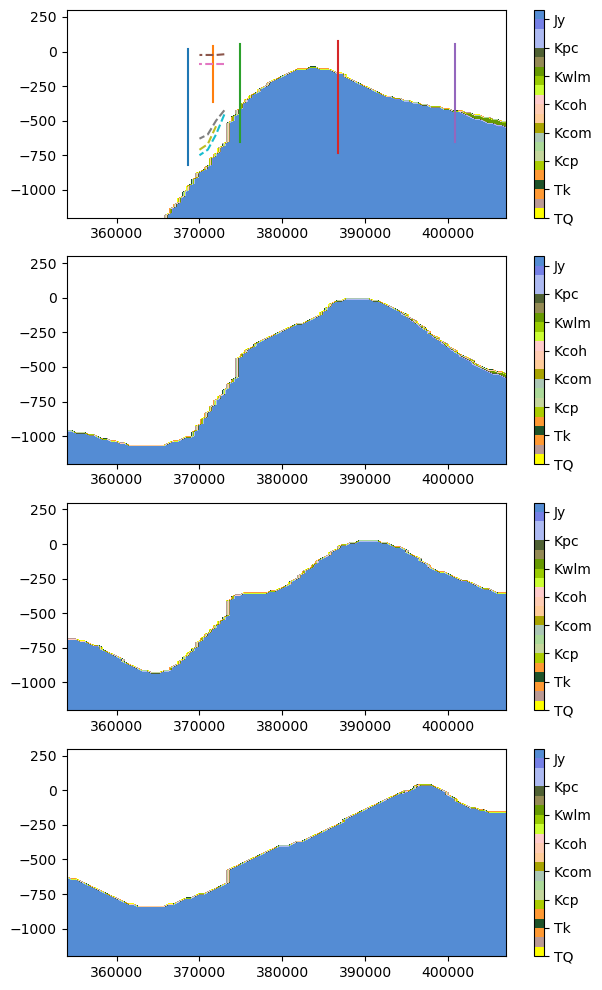

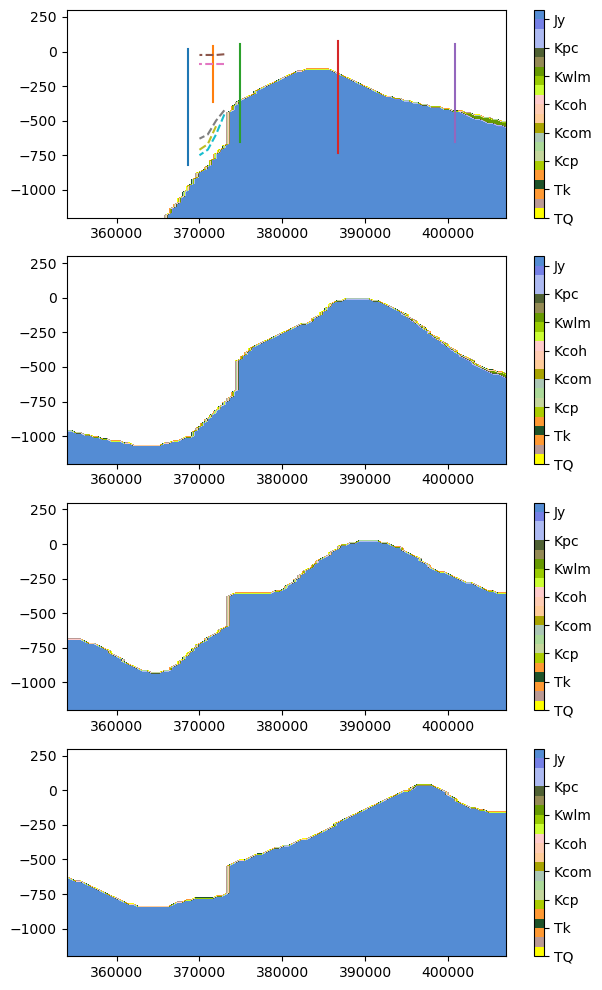

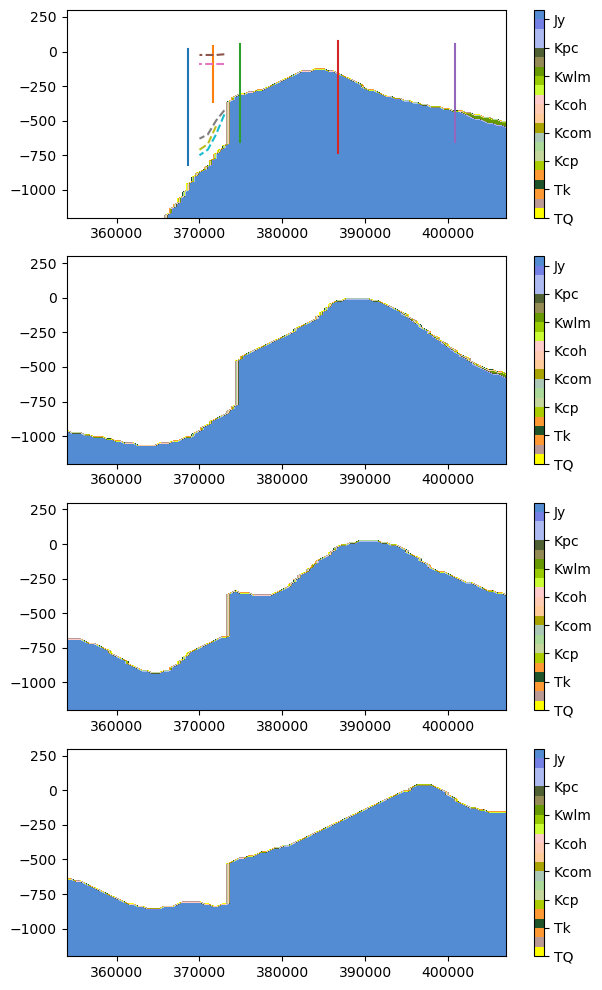

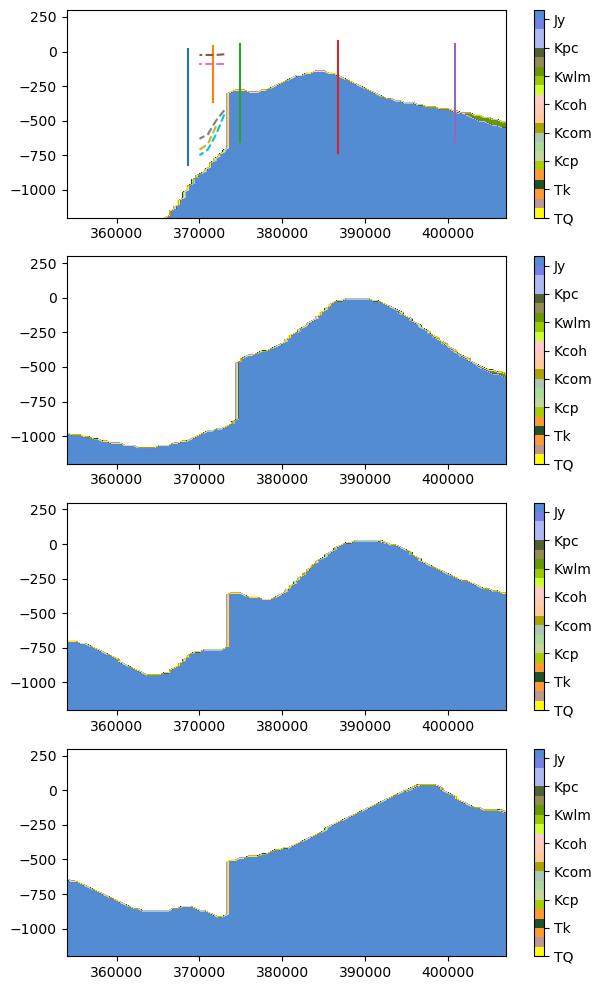

In [5]:
x0, x1, y0, y1, z0, z1 = 354000, 407000, 6488000, 6545000, -1200, 300
origin = np.array([x0, y0, z0]).astype(float)
maximum = np.array([x1, y1, z1]).astype(float)
print(origin,maximum)
dmax = [50.,100.,150.,200.]
for_kerry = []
for j in range(4):
    Lmod = GM(origin,maximum)
    fx = [374540,374541,374000,374700,374750,373500,374000,374001]
    fy = [6490000,6502303,6515000,6520000,6525000,6530000,6545000,6550000]
    #dmax = 150.
    Lmod.add_fault(fx,fy,dmax[j])
    cx = [372107,372107,372107,372107,372107,372107]
    cy = [6528279.3,6528279.3,6528279.3,6528279.3,6528279.3,6528279.3]
    cz = [-700.,-700.,-770,-770.,-770.,-770.]
    cval = [-947,0, -1109,0,0,0]
    cfeat = ['Leederville','NC6_FEAT','Warnbro','NC7_FEAT','NC8_FEAT','NC9_FEAT']
    #Lmod.add_control_points(cx,cy,cz,cval,cfeat)
    Lmod.make_geomodel()
    y_transects = [
        6515000,
        6522790,
        6527971,
        6540939,
    ]

    delx, delz = 100, 100

    x, z = np.linspace(x0, x1, delx), np.linspace(z0, z1, delz)

    xx, zz = np.meshgrid(x, z)

    V_strat_column = []

    i = 0
    import pylab as plt
    plt.figure(figsize=(12, 10))

    for i in range(4):

        yy = np.zeros_like(xx)

        yy[:] = y_transects[i]

        V_strat_column.append(
            Lmod.geomodel.evaluate_model(
                np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
            ).reshape(np.shape(xx))
        )
        plt.subplot(4, 2, i * 2 + 2)

        plt.contourf(
            xx,zz,V_strat_column[i],
            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,22],
            colors=Lmod.strat["color"][1:],
        )
        if i == 0:
            plt.plot([368581,368581],[16,16-838])
            plt.plot([371647,371647],[39,39-405])
            plt.plot([374909,374909],[54,54-708])
            plt.plot([386758,386758],[75,75-810])
            plt.plot([400874,400874],[54,54-708])
            plt.plot([373000,372000,371000,370000],[-20,-25,-25,-25],'--')
            plt.plot([373000,372000,371000,370000],[-90,-90,-90,-90],'--')
            plt.plot([373000,372000,371000,370000],[-425,-500,-600,-630],'--')
            plt.plot([372000,371000,370000],[-540,-670,-710],'--')
            plt.plot([373000,372000,371000,370000],[-455,-600,-710,-750],'--')
            """plt.xlim(400000,401000)
            plt.ylim(-1200,80)"""
        if i == 2:
            for_kerry.append(V_strat_column[-1])
        cbar = plt.colorbar()
        cbar.ax.set_yticklabels(Lmod.lithcodes[1:])

    plt.tight_layout()


In [6]:
Lmod.lithcodes[18]

'Kwg'

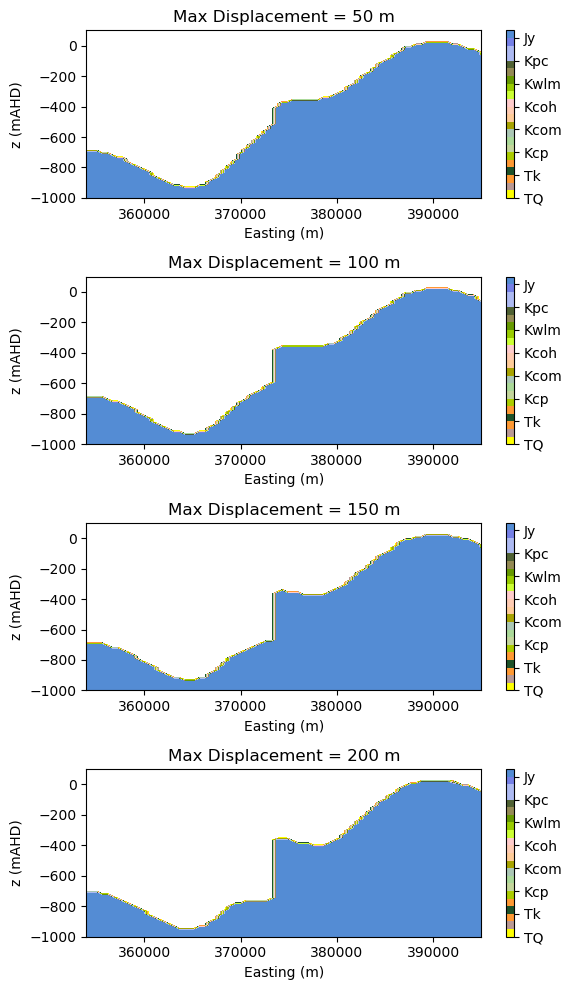

In [7]:
plt.figure(figsize=(6, 10))
for i in range(4):
    yy = np.zeros_like(xx)

    yy[:] = y_transects[2]
    
    plt.subplot(4, 1, i + 1)

    plt.contourf(
        xx,zz,for_kerry[i],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,22],
        colors=Lmod.strat["color"][1:],
    )
    
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(Lmod.lithcodes[1:])
    plt.ylabel('z (mAHD)')
    plt.xlabel('Easting (m)')
    plt.title('Max Displacement = ' +str(int(dmax[i])) + ' m')
    plt.xlim(None,395000)
    plt.ylim(-1000,100)
    plt.xticks([360000,370000,380000,390000],[360000,370000,380000,390000])
plt.tight_layout()

plt.savefig('For_presentation.png',dpi = 450)

    

In [8]:
yy = np.zeros_like(xx)

yy[:] = y_transects[2]


In [9]:

plt.imshow(Lmod.geomodel.evaluate_feature_value("NC9_FEAT",
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx)),origin = "lower") 
plt.colorbar()
plt.contour(Lmod.geomodel.evaluate_feature_value("NC9_FEAT",
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx)),[0.1])

ValueError: NC9_FEAT does not exist!